### Importing Necessary Libraries

In [1]:
!pip install --upgrade pip
!pip install shap
!pip install imbalanced-learn
#!pip install aequitas

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
import shap
from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score, make_scorer, mean_absolute_error, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE

#from aequitas.preprocessing import preprocess_input_df
#from aequitas.group import Group
#from aequitas.bias import Bias
#from aequitas.fairness import Fairness

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('df_1.csv')

In [3]:
cols_to_drop = [col for col in df.columns if df[col].dtype == 'object']
df = df.drop(columns=cols_to_drop)

In [4]:
df

,YearsCode,YearsCodePro,WorkExp,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,Employment_Independent contractor freelancer or self-employed,Employment_Retired,LearnCodeCoursesCert_Codecademy,LearnCodeCoursesCert_Coursera,LearnCodeCoursesCert_Other,LearnCodeCoursesCert_Pluralsight,LearnCodeCoursesCert_Skillsoft,LearnCodeCoursesCert_Udacity,LearnCodeCoursesCert_Udemy,LearnCodeCoursesCert_edX,LanguageHaveWorkedWith_APL,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Flow,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Raku,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SAS,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,DatabaseHaveWorkedWith_BigQuery,DatabaseHaveWorkedWith_Cassandra,DatabaseHaveWorkedWith_Clickhouse,DatabaseHaveWorkedWith_Cloud Firestore,DatabaseHaveWorkedWith_Cockroachdb,DatabaseHaveWorkedWith_Cosmos DB,DatabaseHaveWorkedWith_Couch DB,DatabaseHaveWorkedWith_Couchbase,DatabaseHaveWorkedWith_Datomic,DatabaseHaveWorkedWith_DuckDB,DatabaseHaveWorkedWith_Dynamodb,DatabaseHaveWorkedWith_Elasticsearch,DatabaseHaveWorkedWith_Firebase Realtime Database,DatabaseHaveWorkedWith_Firebird,DatabaseHaveWorkedWith_H2,DatabaseHaveWorkedWith_IBM DB2,DatabaseHaveWorkedWith_InfluxDB,DatabaseHaveWorkedWith_MariaDB,DatabaseHaveWorkedWith_Microsoft Access,DatabaseHaveWorkedWith_Microsoft SQL Server,DatabaseHaveWorkedWith_MongoDB,DatabaseHaveWorkedWith_MySQL,DatabaseHaveWorkedWith_Neo4J,DatabaseHaveWorkedWith_Oracle,DatabaseHaveWorkedWith_PostgreSQL,DatabaseHaveWorkedWith_RavenDB,DatabaseHaveWorkedWith_Redis,DatabaseHaveWorkedWith_SQLite,DatabaseHaveWorkedWith_Snowflake,DatabaseHaveWorkedWith_Solr,DatabaseHaveWorkedWith_Supabase,DatabaseHaveWorkedWith_TiDB,PlatformHaveWorkedWith_Amazon Web Services (AWS),PlatformHaveWorkedWith_Cloudflare,PlatformHaveWorkedWith_Colocation,PlatformHaveWorkedWith_Digital Ocean,PlatformHaveWorkedWith_Firebase,PlatformHaveWorkedWith_Fly.io,PlatformHaveWorkedWith_Google Cloud,PlatformHaveWorkedWith_Heroku,PlatformHaveWorkedWith_Hetzner,PlatformHaveWorkedWith_IBM Cloud Or Watson,"PlatformHaveWorkedWith_Linode, now Akamai",PlatformHaveWorkedWith_Managed Hosting,PlatformHaveWorkedWith_Microsoft Azure,PlatformHaveWorkedWith_Netlify,PlatformHaveWorkedWith_OVH,PlatformHaveWorkedWith_OpenShift,PlatformHaveWorkedWith_OpenStack,PlatformHaveWorkedWith_Oracle Cloud Infrastructure (OCI),PlatformHaveWorkedWith_Render,PlatformHaveWorkedWith_Scaleway,PlatformHaveWorkedWith_VMware,PlatformHaveWorkedWith_Vercel,PlatformHaveWorkedWith_Vultr,WebframeHaveWorkedWith_ASP.NET,WebframeHaveWorkedWith_ASP.NET CORE,WebframeHaveWorkedWith_Angular,WebframeHaveWorkedWith_AngularJS,WebframeHaveWorkedWith_Blazor,WebframeHaveWorkedWith_CodeIgniter,We

# Data Modeling

In [5]:
#Train-Test Split

target = 'ConvertedCompYearly'

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### model1 - RandomForestRegressor

In [6]:
#Initialising and fitting our RandomForestRegressor to data

model1 = RandomForestRegressor(random_state=42, n_jobs=-1)
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

In [7]:
#Model Evaluation

model1_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model1_mae = mean_absolute_error(y_test, y_pred)
model1_r2 = r2_score(y_test, y_pred)
model1_mape = np.mean(np.abs((y_test - y_pred) / (y_test))) * 100

print(f"RFR RMSE: {model1_rmse}")
print(f"RFR MAE: {model1_mae}")
print(f"RFR R²: {model1_r2}")

RFR RMSE: 66087.45589189831
RFR MAE: 45836.809777904324
RFR R²: 0.2974414459195427


In [8]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model1.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.loc[feature_importance.index[:50], ['Feature', 'Importance']]

,Feature,Importance
1,YearsCodePro,0.143038
319,OpSysProfessional use_Windows,0.037674
0,YearsCode,0.035665
390,ProfessionalTech_Observability tools,0.031018
2,WorkExp,0.022554
382,ProfessionalTech_AI-assisted technology tool(s),0.013932
36,LanguageHaveWorkedWith_HTML/CSS,0.012734
368,OfficeStackSyncHaveWorkedWith_Microsoft Teams,0.011769
48,LanguageHaveWorkedWith_PHP,0.011714
335,OfficeStackAsyncHaveWorkedWith_Jira,0.009287


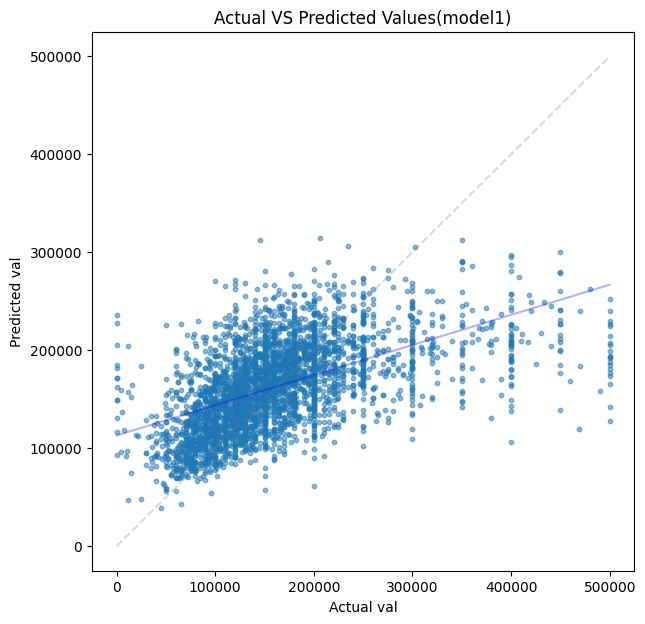

model1_RMSE: 66087.45589189831
model1_MAE: 45836.809777904324
model1_R²: 0.2974414459195427


In [9]:
# Visualising our model performance

plt.figure(figsize=(7,7))
plt.scatter(y_test,y_pred, alpha = 0.5, s=10)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='grey', linestyle='--', label='Perfect Prediction', alpha=0.3)

coefficients = np.polyfit(y_test, y_pred, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(min(y_test), max(y_test), 100)

plt.plot(x_axis, polynomial(x_axis), label='Best Fit Line', color='blue', alpha = 0.3)

plt.xlabel('Actual val')
plt.ylabel('Predicted val')
plt.title('Actual VS Predicted Values(model1)')
plt.show()

print('model1_RMSE:', model1_rmse)
print('model1_MAE:', model1_mae)
print('model1_R²:', model1_r2)

##### RandomForestRegressor after PCA

In [10]:
#Conducting PCA on Independent variables

pca = PCA()
X_pca = pca.fit_transform(X)


#Splitting the data for Training and Testing

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [11]:
#Initialising and fitting our RandomForestRegressor Model

rfr_pca = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rfr_pca.fit(X_train_pca, y_train)

y_pred_pca = rfr_pca.predict(X_test_pca)

In [12]:
#Model Evaluation

rfr_rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
rfr_mae_pca = mean_absolute_error(y_test, y_pred_pca)
rfr_r2_pca = r2_score(y_test, y_pred_pca)

print(f"RFR RMSE after PCA: {rfr_rmse_pca}")
print(f"RFR MAE after PCA: {rfr_mae_pca}")
print(f"RFR R² after PCA: {rfr_r2_pca}")

RFR RMSE after PCA: 67585.57329967873
RFR MAE after PCA: 47393.64667425968
RFR R² after PCA: 0.2652282288516903


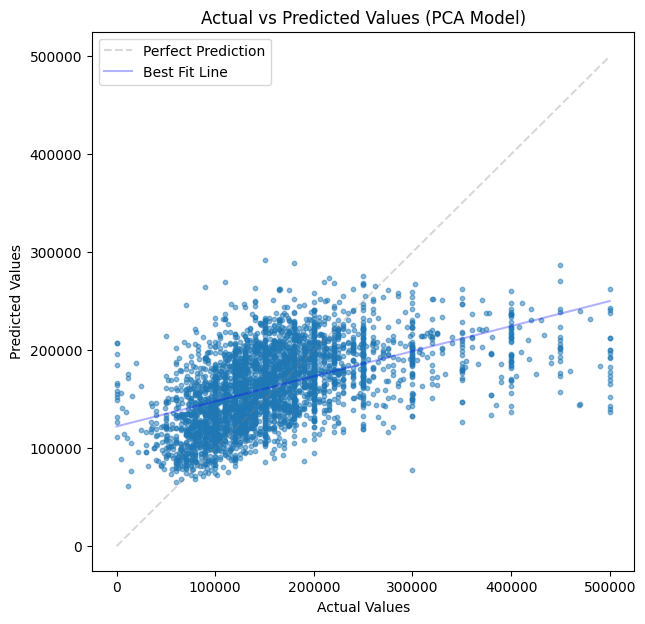

In [13]:
# Visualize PCA model performance
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_pca, alpha=0.5, s=10)

# Perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='grey', linestyle='--', label='Perfect Prediction', alpha=0.3)

# Best fit line
coefficients_pca = np.polyfit(y_test, y_pred_pca, 1)
polynomial_pca = np.poly1d(coefficients_pca)
x_axis_pca = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_axis_pca, polynomial_pca(x_axis_pca), 
         label='Best Fit Line', color='blue', alpha=0.3)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (PCA Model)')
plt.legend()
plt.show()

We see that after conducting PCA, we have lesser variance in our predicted value. However RMSE, MAE and R² show higher errors. The values without PCA spread out alot more. However the PCA didnt solve the issue we were looking to fix. The higher values are still vastly under predicted.

In [14]:
'''
# Using Hyper Parameter Tuning

# Initialising Model
rf = RandomForestRegressor(random_state=42)

# Define a comprehensive parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt']
}

# Define scoring metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, refit='RMSE', cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and scores for RMSE, MAE, R2
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculate metrics on test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print('Best Parameters:', best_params)
print('Best Estimator:', best_rf)
print('Test RMSE with Hyper Parameter Tuning:', test_rmse)
print('Test MAE Hyper Parameter Tuning:', test_mae)
print('Test R² Hyper Parameter Tuning:', test_r2)
''';

After trying a couple of iterations, it seems like the problem lies in the mismatch in density of distribution. We see a steep decline in count of values above 250,000.

In [15]:
print('Values under 250,000:', df[df['ConvertedCompYearly']<=250000].shape[0])
print('Values over 250,000:', df[df['ConvertedCompYearly']>=250000].shape[0])

Values under 250,000: 10599
Values over 250,000: 1428


##### model2 - LinearRegressionModel

In [16]:
X = df.drop(columns = [target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialising and Fitting model
model2 = LinearRegression()
model2.fit(X_train, y_train)


# Making predictions on the test set
y_pred = model2.predict(X_test)


#Model evaluation
model2_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model2_mae = mean_absolute_error(y_test, y_pred)
model2_r2 = r2_score(y_test, y_pred)

print(f"RMSE: {model2_rmse}")
print(f"MAE: {model2_mae}")
print(f"R²: {model2_r2}")

RMSE: 2061222392785557.8
MAE: 34781443239787.133
R²: -6.834301949831918e+20


Linear Regression is underperforming severely, likely due to noise within the data. To mitigate this issue, we can employ Principal Component Analysis (PCA), a dimensionality reduction technique. This approach helps to enhance the model's effectiveness by isolating the most significant features.

##### Applying PCA

In [17]:
X = df.drop('ConvertedCompYearly', axis=1)
y = df['ConvertedCompYearly']


#Conducting PCA on independent variables
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)


#Splitting the data for Training and Testing
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Train a linear regression model
lrm_pca = LinearRegression()
lrm_pca.fit(X_train_pca, y_train)

y_pred = lrm_pca.predict(X_test_pca)

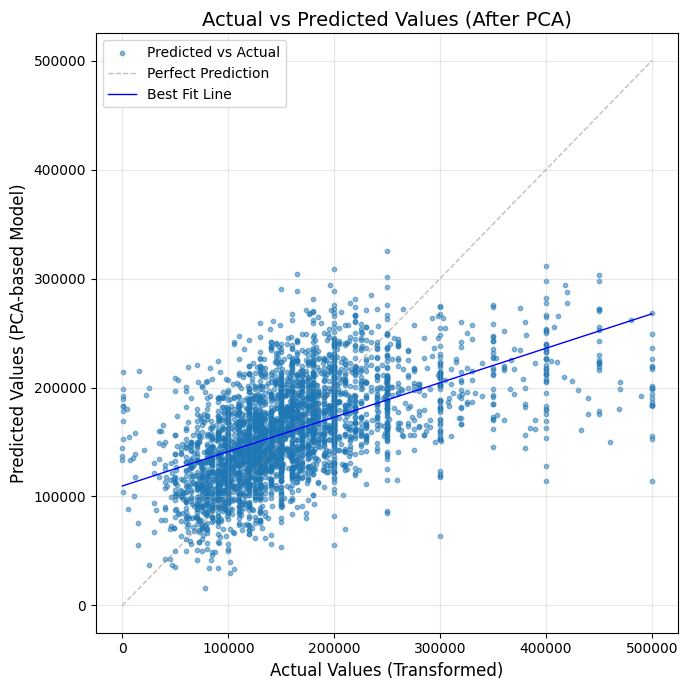

RMSE after PCA: 65934.9206539294
MAE after PCA: 46636.693522130605
R² after PCA: 0.30068082810131447


In [18]:
# Calculating Evaluation Metrics

lrm_pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lrm_pca_mae = mean_absolute_error(y_test, y_pred)
lrm_pca_r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual', s=10)

# Perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='grey', linestyle='--', linewidth=1, label='Perfect Prediction', alpha=0.5)

# Best fit line
coefficients = np.polyfit(y_test, y_pred, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_axis, polynomial(x_axis), color='blue', linewidth=1, label='Best Fit Line')

# Adding labels and title
plt.xlabel('Actual Values (Transformed)', fontsize=12)
plt.ylabel('Predicted Values (PCA-based Model)', fontsize=12)
plt.title('Actual vs Predicted Values (After PCA)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Displaying Evaluation Metrics
print(f"RMSE after PCA: {lrm_pca_rmse}")
print(f"MAE after PCA: {lrm_pca_mae}")
print(f"R² after PCA: {lrm_pca_r2}")

This looks better, but were still facing an issue as higher values are constantly being underpredicted. This is likely because of a bias formed due to higher density on the lower values. We can improve accuracy by using SMOTE and improving density of the 250000> group.

Given our dataset has very few values with `ConvertedCompYearly` above 250000, we can split our dataset into 2 parts. We can then train 2 different models on each dataset and have a third model trained to determine which model should predict the `CombinedCompYearly`.

Steps broken down:

#### 1) Add a column `target_classifier` to determine which model will predict data
We create a column **`model`** with values 
- 0 for < 250000
- 1 for > 250000

#### 2) Split dataset into 
- df_low: Rows with **`CombinedCompYearly`** below 250000
- df_high: Rows with **`CombinedCompYearly`** above 250000

#### 3) Train `model_0` and `model_1` on `df_low` and `df_high` respectively

#### 4) Train `model_rfc` a RandomForestClassifier to determine if the entry belongs to `df_low` or `df_high`

#### 5) Use the assigned model to predict the `ConvertedCompYearly`

In [19]:
df_1 = df.copy()


# Splitting the dataset into two parts based on 'ConvertedCompYearly'
df_low = df_1[df_1['ConvertedCompYearly'] <= 250000]
df_high = df_1[df_1['ConvertedCompYearly'] > 250000]


# Features and target variable for regression models
features_low = df_low.drop(columns=['ConvertedCompYearly'])
target_low = df_low['ConvertedCompYearly']

features_high = df_high.drop(columns=['ConvertedCompYearly'])
target_high = df_high['ConvertedCompYearly']


# Splitting data for classifier
features = df_1.drop(columns=['ConvertedCompYearly'])
target_classifier = np.where(df_1['ConvertedCompYearly'] > 250000, 1, 0)


# Train-test split for all models
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(features_low, target_low, test_size=0.2, random_state=42)

X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(features_high, target_high, test_size=0.2, random_state=42)

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(features, target_classifier, test_size=0.2, random_state=42)


# Model training for df_low
model_0 = RandomForestRegressor(random_state=42)
model_0.fit(X_train_low, y_train_low)
y_pred_low = model_0.predict(X_test_low)


# Model training for df_high
model_1 = RandomForestRegressor(random_state=42)
model_1.fit(X_train_high, y_train_high)
y_pred_high = model_1.predict(X_test_high)


# model_0 evaluation
rmse_low = np.sqrt(mean_squared_error(y_test_low, y_pred_low))
mae_low = mean_absolute_error(y_test_low, y_pred_low)
r2_low = r2_score(y_test_low, y_pred_low)

print(f'model_0 RMSE: {rmse_low}')
print(f'model_0 MAE: {mae_low}')
print(f'model_0 R²: {r2_low}')
print('')


# model_1 evaluation
rmse_high = np.sqrt(mean_squared_error(y_test_high, y_pred_high))
mae_high = mean_absolute_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

print(f'model_1 RMSE: {rmse_high}')
print(f'model_1 MAE: {mae_high}')
print(f'model_1 R²: {r2_high}')
print('')


# Classifier to direct data to either model_0 or model_1
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train_classifier, y_train_classifier)


# model_rfc evaluation
y_pred_rfc = model_rfc.predict(X_test_classifier)
report_rfc = classification_report(y_test_classifier, y_pred_rfc)

accuracy_rfc = accuracy_score(y_test_classifier, y_pred_rfc)

print(f'Accuracy of classifier: {accuracy_rfc}\n')
print(report_rfc)


# Example prediction routing function
def predict_compensation(data):
    model_pred = model_rfc.predict(data)
    if model_pred == 0:
        return model_0.predict(data)
    else:
        return model_1.predict(data)

model_0 RMSE: 41333.494308603586
model_0 MAE: 31508.950929245282
model_0 R²: 0.3568069965307681

model_1 RMSE: 67647.9942738061
model_1 MAE: 55961.916666666664
model_1 R²: -0.00884554789158587

Accuracy of classifier: 0.905595899188381

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2119
           1       1.00      0.00      0.01       222

    accuracy                           0.91      2341
   macro avg       0.95      0.50      0.48      2341
weighted avg       0.91      0.91      0.86      2341



Looking at the precision and recall of values below and above 250000, it is clear that our RandomForestClassifier is simply labeling majority of entries as under 250000. To Combat this issue, we can use SMOTE to balance out our dataset.

In [20]:
df_1 = df.copy()

# Splitting the dataset into two parts based on 'ConvertedCompYearly'
df_low = df_1[df_1[target] <= 250000]
df_high = df_1[df_1[target] > 250000]

# Features and target variable for regression models
features_low = df_low.drop(columns=[target])
target_low = df_low[target]
features_high = df_high.drop(columns=[target])
target_high = df_high[target]

# Splitting data for classifier
features = df_1.drop(columns=[target])
target_classifier = np.where(df_1[target] > 250000, 1, 0)

# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
features_smote, target_classifier_smote = smote.fit_resample(features, target_classifier)

# Train-test split for all models
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(features_low, target_low, test_size=0.2, random_state=42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(features_high, target_high, test_size=0.2, random_state=42)
X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(features_smote, target_classifier_smote, test_size=0.2, random_state=42)

# Model training for df_low
model_0 = RandomForestRegressor(random_state=42)
model_0.fit(X_train_low, y_train_low)
y_pred_low = model_0.predict(X_test_low)

# Model training for df_high
model_1 = RandomForestRegressor(random_state=42)
model_1.fit(X_train_high, y_train_high)
y_pred_high = model_1.predict(X_test_high)

# Classifier training and evaluation
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train_classifier, y_train_classifier)
y_pred_rfc = model_rfc.predict(X_test_classifier)
report_rfc = classification_report(y_test_classifier, y_pred_rfc)
accuracy_rfc = accuracy_score(y_test_classifier, y_pred_rfc)
print(f'Accuracy of classifier: {accuracy_rfc}', '\n')
print(report_rfc, '\n', '\n')

# Model evaluation for df_low
rmse_low = np.sqrt(mean_squared_error(y_test_low, y_pred_low))
mae_low = mean_absolute_error(y_test_low, y_pred_low)
r2_low = r2_score(y_test_low, y_pred_low)
print(f'model_0 RMSE: {rmse_low}')
print(f'model_0 MAE: {mae_low}')
print(f'model_0 R²: {r2_low}')
print('')
print('')

# Model evaluation for df_high
rmse_high = np.sqrt(mean_squared_error(y_test_high, y_pred_high))
mae_high = mean_absolute_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)
print(f'model_1 RMSE: {rmse_high}')
print(f'model_1 MAE: {mae_high}')
print(f'model_1 R²: {r2_high}')


# Prediction routing function
def predict_compensation(data):
    model_pred = model_rfc.predict(data)
    if model_pred == 0:
        return model_0.predict(data)
    else:
        return model_1.predict(data)

Accuracy of classifier: 0.9452830188679245 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2160
           1       0.95      0.93      0.94      2080

    accuracy                           0.95      4240
   macro avg       0.95      0.95      0.95      4240
weighted avg       0.95      0.95      0.95      4240
 
 

model_0 RMSE: 41333.494308603586
model_0 MAE: 31508.950929245282
model_0 R²: 0.3568069965307681


model_1 RMSE: 67647.9942738061
model_1 MAE: 55961.916666666664
model_1 R²: -0.00884554789158587


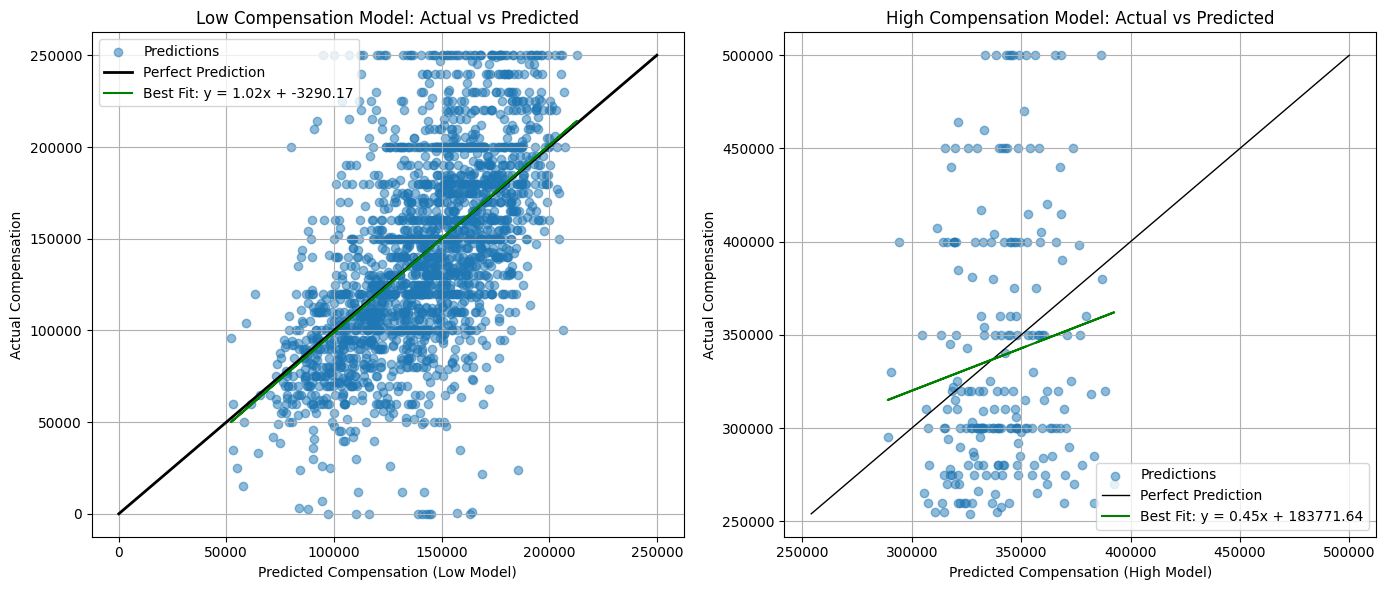

In [21]:
# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot for Low Compensation Model
plt.subplot(1, 2, 1)
plt.scatter(y_pred_low, y_test_low, alpha=0.5, label='Predictions')

# Add perfect prediction line
plt.plot([y_test_low.min(), y_test_low.max()], [y_test_low.min(), y_test_low.max()], color = 'black', lw=2, label='Perfect Prediction')

# Add best fit line
m_low, b_low = np.polyfit(y_pred_low, y_test_low, 1)
plt.plot(y_pred_low, m_low*y_pred_low + b_low, color='green', label=f'Best Fit: y = {m_low:.2f}x + {b_low:.2f}')

plt.xlabel('Predicted Compensation (Low Model)')
plt.ylabel('Actual Compensation')
plt.title('Low Compensation Model: Actual vs Predicted')
plt.legend()
plt.grid(True)

# Plot for High Compensation Model
plt.subplot(1, 2, 2)
plt.scatter(y_pred_high, y_test_high, alpha=0.5, label='Predictions')

# Add perfect prediction line
plt.plot([y_test_high.min(), y_test_high.max()], [y_test_high.min(), y_test_high.max()], color = 'black', lw=1, label='Perfect Prediction')

# Add best fit line
m_high, b_high = np.polyfit(y_pred_high, y_test_high, 1)
plt.plot(y_pred_high, m_high*y_pred_high + b_high, color='green', label=f'Best Fit: y = {m_high:.2f}x + {b_high:.2f}')

plt.xlabel('Predicted Compensation (High Model)')
plt.ylabel('Actual Compensation')
plt.title('High Compensation Model: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
df_1 = pd.read_csv('CleanedData.csv').copy()
target = 'ConvertedCompYearly'

In [23]:
df_1['Country']

0                                 United States of America
1                                 United States of America
2                                 United States of America
3                                              Philippines
4        United Kingdom of Great Britain and Northern I...
                               ...                        
47665                                               Brazil
47666                                              Armenia
47667                                                India
47668                                               France
47669                                               Greece
Name: Country, Length: 47670, dtype: object

In [24]:
# Retaining only users working in the US
df_1 = df_1.loc[df_1['Country'] == 'United States of America']
df_1.drop(columns=['Country'], inplace=True)
df_1=df_1.reset_index(drop=True)

df_1.drop(columns=['Currency'], inplace=True)
df_1 = df_1.reset_index(drop=True)

In [25]:
# Dropping the 'WantToWorkWith' columns
work_with = [col for col in df_1.columns if col.__contains__('WantToWorkWith')]
df_1.drop(columns = work_with, inplace = True)

In [26]:
def preprocess_data(df, target_variable):
    df = df.copy()
    
    # Initialize columns lists
    list_cols = []
    categorical_cols = []

    # Check each column to categorize them correctly
    for col in df.columns:
        if col != target_variable and df[col].dtype == 'object':
            if df[col].str.contains('\[.*\]').any():
                list_cols.append(col)
            else:
                categorical_cols.append(col)

    for col in list_cols:
        # Only convert strings that look like lists
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if (isinstance(x, str) and x.startswith('[') and x.endswith(']')) else x)

    # MultiLabel Binarization for list-based columns
    mlb = MultiLabelBinarizer()
    for col in list_cols:
        # Ensure that only list items are binarized
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
        encoded_col = pd.DataFrame(
            mlb.fit_transform(df[col]),
            columns=[f"{col}_{value}" for value in mlb.classes_],
            index=df.index
        )
        df = pd.concat([df, encoded_col], axis=1)

    # Drop original list-based columns
    df.drop(columns=list_cols, inplace=True)

    # One-Hot Encoding for categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

# Applying Pre-Processing
df_1 = preprocess_data(df_1, target)

In [27]:
# Create a binary target for SMOTE
df_1['binary_target'] = (df_1[target] > 250000).astype(int)

# Splitting data
features = df_1.drop(columns=[target, 'binary_target'])
binary_target = df_1['binary_target']
continuous_target = df_1[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, continuous_target, test_size=0.2, random_state=42, stratify=binary_target)

In [28]:
# Remove classes with two or fewer samples in the training set
class_counts = y_train.value_counts()
sufficient_samples = class_counts[class_counts > 2].index
sufficient_indices = y_train.isin(sufficient_samples)
X_train_filtered = X_train[sufficient_indices]
y_train_filtered = y_train[sufficient_indices]

# Applying SMOTE to the filtered training data with k_neighbors set to 2
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train_filtered, y_train_filtered)

# Applying PCA to the training data
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

# Initiating and Training Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, y_train_smote)

# Predictions
y_pred = model.predict(X_test_pca)

RMSE: 78108.7282255326
R² Score: 0.009450737180961677


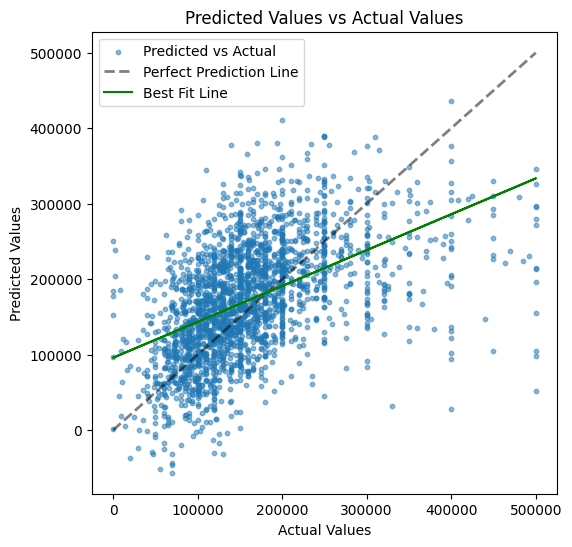

In [29]:
# Model evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

# Plotting predicted values vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.5, label='Perfect Prediction Line')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='green', label='Best Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Actual Values')
plt.legend()
plt.show()

It seems to be that resampling to train our model on a more blanced data doesn't positively impact our model predictions. Instead we see a tradeoff where a minimal improvement in the higher values is also reflected in the lower values which infact takes them away from the perfect prediction line. This increase variance, thus impacting our RMSE, MAE and R². 

# Best Model

In [30]:
X = df.drop(columns = [target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialising and Fitting model
model2 = LinearRegression()
model2.fit(X_train, y_train)


# Making predictions on the test set
y_pred = model2.predict(X_test)


#Model evaluation
model2_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model2_mae = mean_absolute_error(y_test, y_pred)
model2_r2 = r2_score(y_test, y_pred)

print(f"RMSE: {model2_rmse}")
print(f"MAE: {model2_mae}")
print(f"R²: {model2_r2}")

RMSE: 2061222392785557.8
MAE: 34781443239787.133
R²: -6.834301949831918e+20


In [31]:
X = df.drop('ConvertedCompYearly', axis=1)
y = df['ConvertedCompYearly']


#Conducting PCA on independent variables
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)


#Splitting the data for Training and Testing
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Train a linear regression model
lrm_pca = LinearRegression()
lrm_pca.fit(X_train_pca, y_train)

y_pred = lrm_pca.predict(X_test_pca)

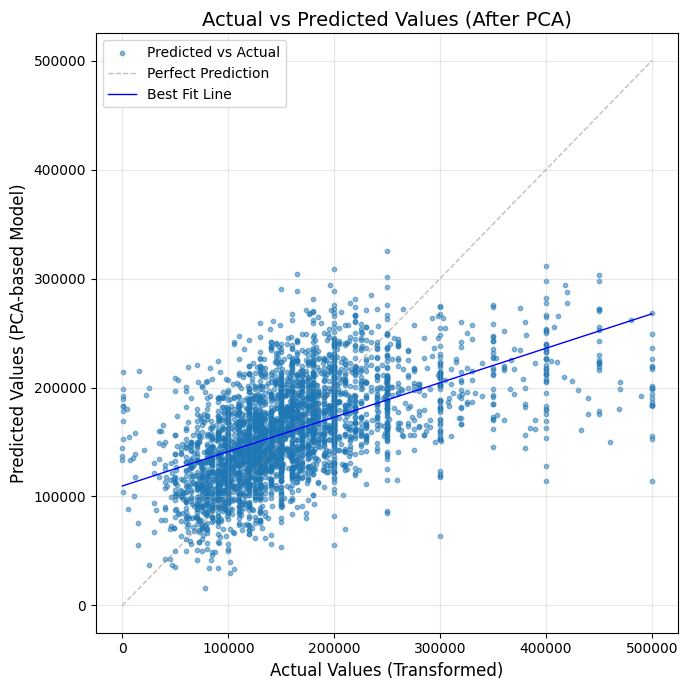

RMSE after PCA: 65934.9206539294
MAE after PCA: 46636.693522130605
R² after PCA: 0.30068082810131447


In [32]:
# Calculating Evaluation Metrics
lrm_pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lrm_pca_mae = mean_absolute_error(y_test, y_pred)
lrm_pca_r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual', s=10)

# Perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='grey', linestyle='--', linewidth=1, label='Perfect Prediction', alpha=0.5)

# Best fit line
coefficients = np.polyfit(y_test, y_pred, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_axis, polynomial(x_axis), color='blue', linewidth=1, label='Best Fit Line')

# Adding labels and title
plt.xlabel('Actual Values (Transformed)', fontsize=12)
plt.ylabel('Predicted Values (PCA-based Model)', fontsize=12)
plt.title('Actual vs Predicted Values (After PCA)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Displaying Evaluation Metrics
print(f"RMSE after PCA: {lrm_pca_rmse}")
print(f"MAE after PCA: {lrm_pca_mae}")
print(f"R² after PCA: {lrm_pca_r2}")